# Fit annual harmonics to the atlas monthly amplitude data

In [1]:
import xarray as xr
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from matplotlib import rcParams

from soda.utils import harmonic_analysis as ha
from soda.utils import othertime
from scipy.fftpack import fft2, ifft2, fftfreq

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cmocean as cm

In [2]:

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'


In [3]:
%matplotlib notebook

In [4]:
# inputs
vmax=10
cmap=cm.cm.amp

atlasfile = r'C:\Users\mrayson\cloudstor\Data\IWAtlas\NWS_internal_tide_atlas_GLORYS.nc'
figpath = 'C:/Users/mrayson/Dropbox/ProjectsActive/ARCHub/DOCS-ARCHub-Dropbox/AMOS2020/'

# Domain for spatial decomposition
xlims = [112,126]
ylims = [-22,-8]

In [5]:
# frq, names = ha.getTideFreq(['SA','SSA','120d','90d'])
omega_A = 2*np.pi/(365.25*86400.)
frqlow = [n*omega_A for n in range(3)]

In [6]:
ha.harmonic_fit_array?

In [8]:
# ds_all = xr.open_dataset(r'/home/suntans/cloudstor/Data/IWAtlas/NWS_internal_tide_atlas.nc',)
ds_all = xr.open_dataset(atlasfile, chunks={})


#ds = ds_all.sel(modes=0)
ds = ds_all.sel(longitude=188.5, latitude=-16.66,  method='nearest')
ds_all

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\dask\array\core.py:1252: RuntimeWarning: overflow encountered in long_scalars
  cbytes = format_bytes(np.prod(self.chunksize) * self.dtype.itemsize)


<xarray.Dataset>
Dimensions:    (depth: 80, frq: 5, latitude: 1000, longitude: 1750, modes: 4, time: 23)
Coordinates:
  * time       (time) datetime64[ns] 2013-07-16 2013-07-31 ... 2014-06-11
  * frq        (frq) float64 0.0001405 0.0001454 0.0001379 7.292e-05 6.76e-05
  * modes      (modes) float64 0.0 1.0 2.0 3.0
  * latitude   (latitude) float64 -25.0 -24.98 -24.96 ... -5.06 -5.04 -5.02
  * longitude  (longitude) float64 107.5 107.5 107.5 107.6 ... 142.4 142.5 142.5
  * depth      (depth) float64 4.112 12.71 21.69 ... 5.73e+03 5.996e+03
Data variables:
    amp_b      (time, frq, modes, latitude, longitude) float64 dask.array<chunksize=(23, 5, 4, 1000, 1750), meta=np.ndarray>
    phs_b      (time, frq, modes, latitude, longitude) float64 dask.array<chunksize=(23, 5, 4, 1000, 1750), meta=np.ndarray>
    amp_u      (time, frq, modes, latitude, longitude) float64 dask.array<chunksize=(23, 5, 4, 1000, 1750), meta=np.ndarray>
    phs_u      (time, frq, modes, latitude, longitude) float64 dask.array<chunksize=(23, 5, 4, 1000, 1750), meta=np.ndarray>
    amp_v      (time, frq, modes, latitude, longitude) float64 dask.array<chunksize=(23, 5, 4, 1000, 1750), meta=np.ndarray>
    phs_v      (time, frq, modes, latitude, longitude) float64 dask.array<chunksize=(23, 5, 4, 1000, 1750), meta=np.ndarray>
    z          (latitude, longitude) float64 dask.array<chunksize=(1000, 1750), meta=np.ndarray>
    rho        (time, depth, latitude, longitude) float64 dask.array<chunksize=(23, 80, 1000, 1750), meta=np.ndarray>
Attributes:
    Name:          North West Shelf internal tide amplitude climatology
    Date created:  2019:11:27 13:44:05
    Author:        Matt Rayson
    Institution:   University of Western Australia
    Input Files:   ['SCENARIOS/OUTPUT_NWS_2km_GLORYS_hex_2013_2014/NWS_2km_20...

# See other notebook for nomenclature

`nonstationary_harmonic_fit.ipynb`



In [9]:
ff=0 # M2
mm=0 # mode-1

# amp_b = ds.amp_b[:,ff,mm,:,:]
# phs_b = ds.phs_b[:,ff,mm,:,:]

Aa = ds_all.amp_b[:,ff,mm,...]*np.cos(ds_all.phs_b[:,ff,mm,...]) 
Ba = ds_all.amp_b[:,ff,mm,...]*np.sin(ds_all.phs_b[:,ff,mm,...]) 
Aa.shape

(23, 1000, 1750)

In [10]:
tseclow = othertime.SecondsSince(ds.time.values)
nfrq = 1
nfrqlow = len(frqlow)
nt,ny,nx = Aa.shape

In [11]:
# 2) Fit the low-frequency harmonics to these harmonics
aa_l_r = np.zeros((ny,nx))
Aa_l_r = np.zeros((nfrqlow,ny,nx))
Ba_l_r = np.zeros((nfrqlow,ny,nx))

aa_l_i = np.zeros((ny,nx))
Aa_l_i = np.zeros((nfrqlow,ny,nx))
Ba_l_i = np.zeros((nfrqlow,ny,nx))

# Real amplitude
Y = ha.harmonic_fit_array(Aa.values, tseclow, frqlow, axis=0)
aa_l_r[:] = Y[0,...]
Aa_l_r[:] = Y[1::2,...]
Aa_l_i[:] = Y[2::2,...]

# Imaginary amplitude
Y = ha.harmonic_fit_array(Ba.values, tseclow, frqlow, axis=0)
aa_l_i[:] = Y[0,...]
Ba_l_r[:] = Y[1::2,...]
Ba_l_i[:] = Y[2::2,...]

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\soda\utils\harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)
c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\soda\utils\harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [12]:
np.nanmax(myamp_re_mu), myamp_re_re.shape

NameError: name 'myamp_re_mu' is not defined

In [ ]:
# ii = 0
# amp_SA_re = myamp_re[2*ii+1,...]*np.cos(myamp_re[2*ii+2,...]) + \
#     1j*(myamp_re[2*ii+1,...]*np.sin(myamp_re[2*ii+2,...]))



<IPython.core.display.Javascript object>


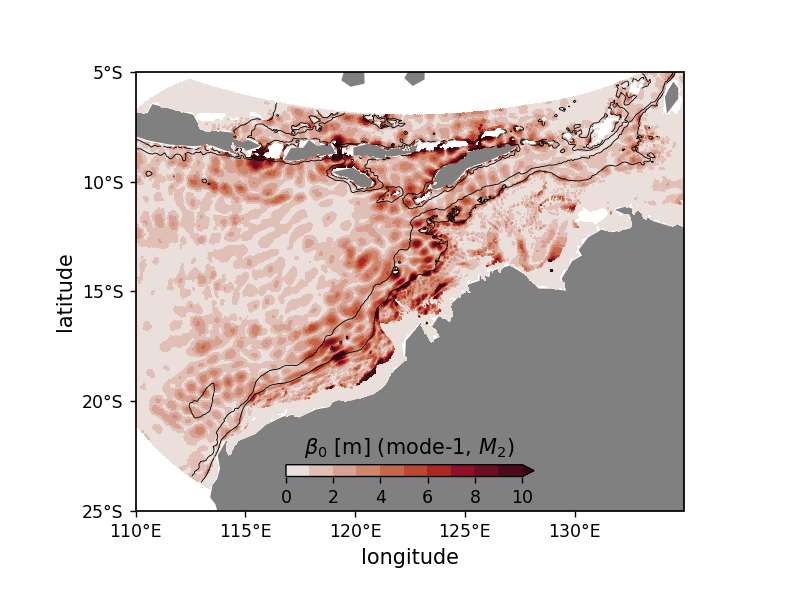

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [19]:
# Plot the "mean" harmonic amplitude

mean_amp = np.abs(aa_l_r + 1j*aa_l_i)


fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([110, 135, -25, -5], crs=ccrs.PlateCarree())
plt.contourf(ds_all.longitude, ds_all.latitude,\
               mean_amp,\
               np.arange(0,11),
               vmax=vmax,  transform=ccrs.PlateCarree(),
              cmap=cm.cm.amp,  extend='max')

#ax.coastlines( resolution='low')
ax.add_feature(cfeature.LAND, facecolor='0.5',edgecolor=None,)
#ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.COASTLINE,fc='0.5')
#plt.pcolormesh(ds.longitude, ds.latitude, np.abs(amp_SA),vmax=10)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([110,115,120,125,130], crs=ccrs.PlateCarree())
ax.set_yticks([-25,-20,-15,-10,-5], crs=ccrs.PlateCarree())

#ax.gridlines()

# plt.plot([xlims[0],xlims[1],xlims[1],xlims[0],xlims[0]],
#         [ylims[0],ylims[0],ylims[1],ylims[1],ylims[0]],
#          'k--',lw=2,transform=ccrs.PlateCarree(),)


cb=plt.colorbar(shrink=0.4, orientation='horizontal',pad=-0.10)
cb.ax.set_title(r'$\beta_0$ [m] (mode-1, $M_2$) ')
ds_all.z.plot.contour(levels=[200,1000], colors='k',linewidths=0.5,
                transform=ccrs.PlateCarree() )
plt.tight_layout()

# plt.savefig('{}/ModeAmp_mean.png'.format(figpath),dpi=150)

In [20]:
# # Plot the M2 annual amplitude
# m2_re = myamp_re_re + 1j* myamp_re_im
# m2_im = myamp_im_re + 1j* myamp_im_im

# m2_amp = np.abs( m2_re + 1j*m2_im)
# m2_amp.shape

In [21]:
# Plot the M2 annual amplitude
m2_re = Aa_l_r + 1j* Aa_l_i
m2_im = Ba_l_r + 1j* Ba_l_r

m2_amp = np.abs( np.abs( m2_re) + 1j*np.abs(m2_im) )
m2_amp.shape

(3, 1000, 1750)

<IPython.core.display.Javascript object>


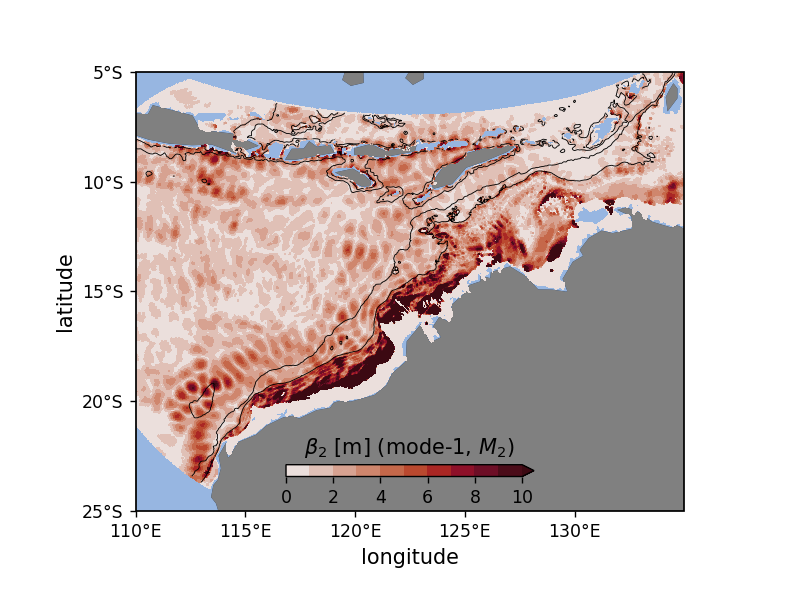

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [28]:
kk = 1# Seasonal harmonic

fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([110, 135, -25, -5], crs=ccrs.PlateCarree())
p1=plt.contourf(ds_all.longitude, ds_all.latitude,\
               m2_amp[kk,...],\
               np.arange(0,11),
               vmax=10,  transform=ccrs.PlateCarree(),
              cmap=cm.cm.amp,  extend='max')

ds_all.z.plot.contour(levels=[200,1000], colors='k',linewidths=0.5,
                transform=ccrs.PlateCarree() )
#ax.coastlines( resolution='low')
ax.add_feature(cfeature.LAND, facecolor='0.5',edgecolor='k',)
ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.COASTLINE)
#plt.pcolormesh(ds.longitude, ds.latitude, np.abs(amp_SA),vmax=10)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([110,115,120,125,130], crs=ccrs.PlateCarree())
ax.set_yticks([-25,-20,-15,-10,-5], crs=ccrs.PlateCarree())

#ax.gridlines()

cb=plt.colorbar(p1,shrink=0.4, orientation='horizontal',pad=-0.10)
cb.ax.set_title(r'$\beta_{}$ [m] (mode-1, $M_2$) '.format(kk+1))
plt.tight_layout()
# plt.savefig('{}/ModeAmp_k{}.png'.format(figpath,kk),dpi=150)

# Hilbert transform filter the mean frequency


In [23]:
i1=ds_all.longitude.searchsorted(xlims[0])
i2=ds_all.longitude.searchsorted(xlims[1])

j1=ds_all.latitude.searchsorted(ylims[0])
j2=ds_all.latitude.searchsorted(ylims[1])

In [44]:
# Perform a 2D fft
# Compute the fft
#z = myamp_re_mu[j1:j2,i1:i2]+1j*myamp_im_mu[j1:j2,i1:i2]
kk=0
z = m2_re[kk,j1:j2,i1:i2] + 1j*m2_im[kk,j1:j2,i1:i2]
z[np.isnan(z)] = 0
y= ds_all.latitude[j1:j2]
x= ds_all.longitude[i1:i2]


My,Mx = z.shape
Z = fft2(z,shape=[My,Mx])

# # Compute zonal frequencies
# dx = x[1]-x[0]
# k = fftfreq(Mx, dx/(2*np.pi))
# dk = 1/(Mx*dx)

# # Compute meridional frequencies
# dy = y[1]-y [0]
# l = fftfreq(Mx, dx/(2*np.pi))
# dl = 1/(My*dy)

In [45]:
Z_posk_posl = np.zeros_like(Z)
Z_posk_posl[:My//2, :Mx//2] = Z[:My//2, :Mx//2] 

z_posk_posl = ifft2(Z_posk_posl,shape=[My,Mx])

Z_posk_negl = np.zeros_like(Z)
Z_posk_negl[:My//2, Mx//2::] = Z[:My//2, Mx//2::] 

z_posk_negl = ifft2(Z_posk_negl,shape=[My,Mx])

Z_negk_negl = np.zeros_like(Z)
Z_negk_negl[My//2::, Mx//2::] = Z[My//2::, Mx//2::] 

z_negk_negl = ifft2(Z_negk_negl,shape=[My,Mx])

Z_negk_posl = np.zeros_like(Z)
Z_negk_posl[My//2::, :Mx//2] = Z[My//2::, :Mx//2] 

z_negk_posl = ifft2(Z_negk_posl,shape=[My,Mx])

<IPython.core.display.Javascript object>


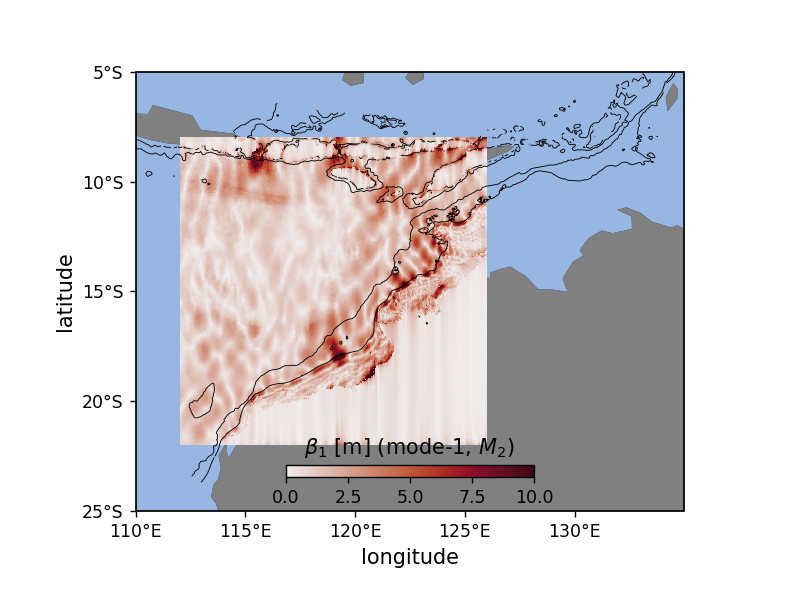

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


In [46]:
fig=plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([110, 135, -25, -5], crs=ccrs.PlateCarree())
# p1=plt.contourf(ds_all.longitude, ds_all.latitude,\
#                m2_amp[kk,...],\
#                np.arange(0,11),
#                vmax=10,  transform=ccrs.PlateCarree(),
#               cmap=cm.cm.amp,  extend='max')

p1=plt.pcolormesh(x,y,np.abs(z_negk_negl+z_negk_posl), cmap=cmap, \
                  vmax=vmax, vmin=0, transform=ccrs.PlateCarree() )

ds_all.z.plot.contour(levels=[200,1000], colors='k',linewidths=0.5,
                transform=ccrs.PlateCarree() )
#ax.coastlines( resolution='low')
ax.add_feature(cfeature.LAND, facecolor='0.5',edgecolor='k',)
ax.add_feature(cfeature.OCEAN)
#ax.add_feature(cfeature.COASTLINE)
#plt.pcolormesh(ds.longitude, ds.latitude, np.abs(amp_SA),vmax=10)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks([110,115,120,125,130], crs=ccrs.PlateCarree())
ax.set_yticks([-25,-20,-15,-10,-5], crs=ccrs.PlateCarree())

#ax.gridlines()

cb=plt.colorbar(p1,shrink=0.4, orientation='horizontal',pad=-0.10)
cb.ax.set_title(r'$\beta_{}$ [m] (mode-1, $M_2$) '.format(kk+1))
plt.tight_layout()
# plt.savefig('{}/ModeAmp_k{}.png'.format(figpath,kk),dpi=150)

<IPython.core.display.Javascript object>


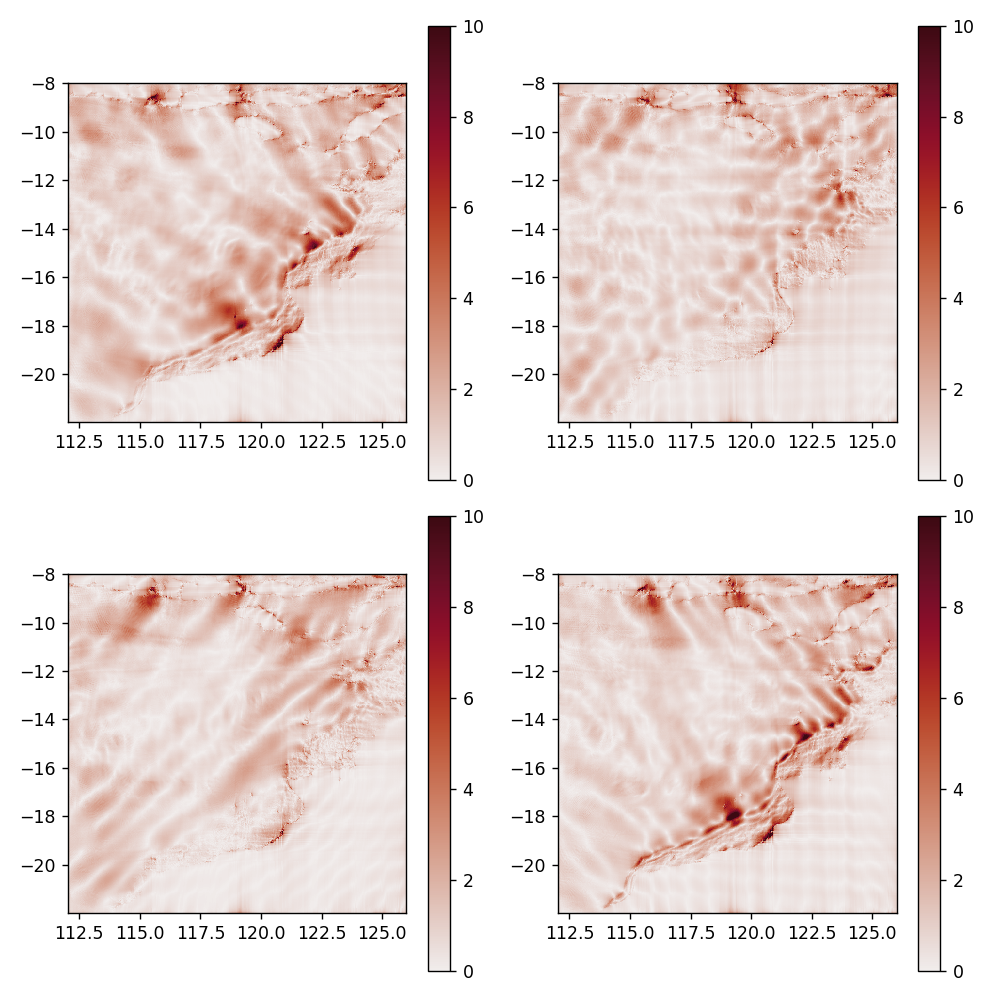

In [47]:
plt.figure(figsize=(8,8))
ax=plt.subplot(221)
plt.pcolormesh(x,y,np.abs(z_posk_negl), cmap=cmap, vmax=vmax, vmin=0)
plt.colorbar()
# plt.contour(X,Y,depth, depthlevs, colors='k', linewidths=0.5)
ax.set_aspect('equal')


ax=plt.subplot(222)
plt.pcolormesh(x,y,np.abs(z_posk_posl), cmap=cmap, vmax=vmax, vmin=0)
plt.colorbar()
# plt.contour(X,Y,depth, depthlevs, colors='k', linewidths=0.5)
ax.set_aspect('equal')

ax=plt.subplot(223)
plt.pcolormesh(x,y,np.abs(z_negk_negl), cmap=cmap, vmax=vmax, vmin=0)
plt.colorbar()
# plt.contour(X,Y,depth, depthlevs, colors='k', linewidths=0.5)
ax.set_aspect('equal')

ax=plt.subplot(224)
p4=plt.pcolormesh(x,y,np.abs(z_negk_posl), cmap=cmap, vmax=vmax, vmin=0)
plt.colorbar()
# plt.contour(X,Y,depth, depthlevs, colors='k', linewidths=0.5)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


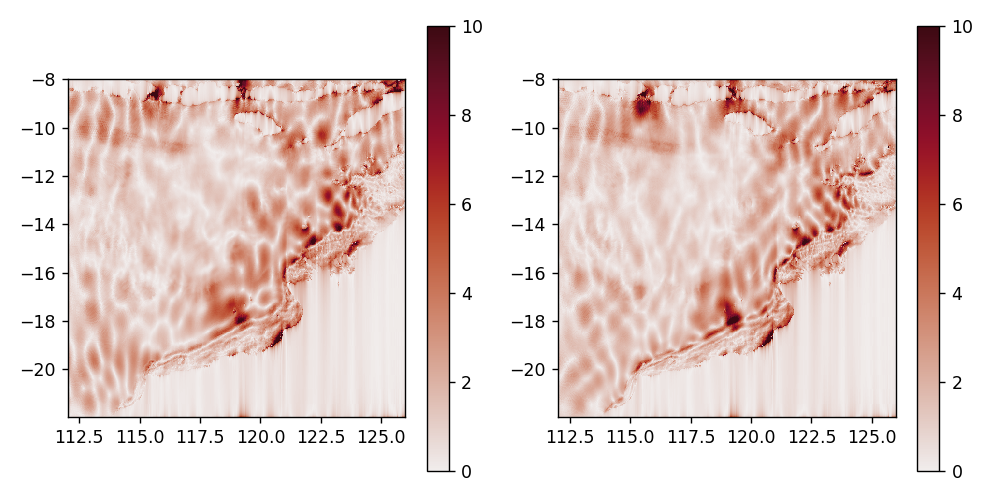

In [48]:
plt.figure(figsize=(8,4))
ax=plt.subplot(121)
plt.pcolormesh(x,y,np.abs(z_posk_negl+z_posk_posl), cmap=cmap, vmax=vmax, vmin=0)
plt.colorbar()
# plt.contour(X,Y,depth, depthlevs, colors='k', linewidths=0.5)
ax.set_aspect('equal')


ax=plt.subplot(122)
plt.pcolormesh(x,y,np.abs(z_negk_negl+z_negk_posl), cmap=cmap, vmax=vmax, vmin=0)
plt.colorbar()
# plt.contour(X,Y,depth, depthlevs, colors='k', linewidths=0.5)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()